# Inhibitor Diffusion and Germination - Three dimensions

## Numerical experiments - Week 47/2024

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda, float32
import plotly.graph_objects as go

## 1. General assumptions

The spore is now situated in a three-dimensional volume, being able to diffuse in more directions.

The assumptions on permeation through the cell wall and in the medium are as in the previous experiment, but the PDE solutions now extend to three dimensions and all sides of the spore are subject to inhibitor flux.

## 2. Algorithmic framework

### 2.1. Analytical formula

First, a function for obtaining the analytical solution is defined as in the previous experiment.

In [2]:
def permeation_time_dependent_analytical(c_in, c_out, t, Ps, A, V, alpha=1.0):
    """
    Compute the concentration of a solute in a spore given the initial and external concentrations.
    inputs:
        c_in (float) - the initial concentration of the solute;
        c_out (float) - the external concentration of the solute;
        t (float) - time;
        Ps (float) - the spore membrane permeation constant;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore;
        alpha (float) - permeable fraction of the area; defaults to 1.
    """
    tau = V / (alpha * A * Ps)
    c = c_out - (c_out - c_in) * np.exp(-t / tau)
    return c

With it, it can be quickly compared how the number of dimensions affects the concentraiton change

In [3]:
Ps = 1.9e-6
t_max = 14400 # 4 hours
times = np.linspace(0, t_max, 1000)
alpha = 10.0
spore_wall_vol = 125

# 2D setup
spore_area = 20 # 4 sides of square
c_analytical_2D = permeation_time_dependent_analytical(1, 0, times, Ps, spore_area, spore_wall_vol, alpha)

# 3D setup
spore_area = 150
c_analytical_3D = permeation_time_dependent_analytical(1, 0, times, Ps, spore_area, spore_wall_vol, alpha)

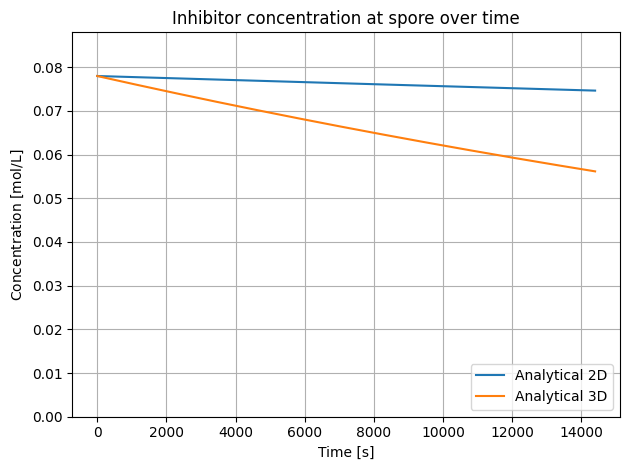

In [ ]:
c_scale = 0.078
c_analytical_2D_scaled = c_scale * c_analytical_2D
c_analytical_3D_scaled = c_scale * c_analytical_3D

# Plot the concentration evolution
fig, ax = plt.subplots()
ax.plot(times, c_analytical_2D_scaled, label='Analytical 2D')
ax.plot(times, c_analytical_3D_scaled, label='Analytical 3D')
ax.set_ylim(0, c_scale+0.01)
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Concentration $[\text{mol}/\text{L}]$')
ax.set_title('Inhibitor concentration at spore over time')
ax.legend(loc='lower right')
ax.grid()
fig.tight_layout()

### 2.2. Numerical algorithm

To test this against finite-size effects, a 3D lattice-based model is constructed, similar to the previous experiments. As the spores will be positioned close to an impermeable bottom surface, the two boundaries in the $z$-dimension are set with a Dirichlet boundary condition of $c(x,y,z,t)=0$.

In [ ]:
def invoke_smart_kernel(size, threads_per_block=(16, 16, 16)):
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = [(size + (tpb - 1)) // tpb for tpb in threads_per_block]
    return tuple(blocks_per_grid), tuple(threads_per_block)


@cuda.jit()
def update_GPU(c_old, c_new, dtdx2, D, Dm, spore_idx):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (numpy.ndarray) - the current state of the lattice;
        c_new (numpy.ndarray) - the next state of the lattice;
        dtdx2 (float) - the update factor;
        D (float) - the diffusion constant through the medium;
        Dm (float) - the diffusion constant through the spore membrane;
        spore_idx (tuple) - the indices of the spore location.
    """
    i, j, k = cuda.grid(3)

    if i >= c_old.shape[0] or j >= c_old.shape[1]:
        return
    
    if k == 0 or k == c_old.shape[2] - 1:
        return

    center = c_old[i, j, k]
    bottom = c_old[(i - 1) % c_old.shape[0], j, k]
    top = c_old[(i + 1) % c_old.shape[0], j, k]
    left = c_old[i, (j - 1) % c_old.shape[1], k]
    right = c_old[i, (j + 1) % c_old.shape[1], k]
    front = c_old[i, j, (k - 1) % c_old.shape[2]]
    back = c_old[i, j, (k + 1) % c_old.shape[2]]
    
    Ddtdx2 = cuda.local.array(6, float32)
    for k in range(6):
        Ddtdx2[k] = D * dtdx2

    if i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2]:
        for k in range(6):
            Ddtdx2[k] = Dm * dtdx2
    elif i == spore_idx[0] - 1 and j == spore_idx[1] and k == spore_idx[2]:
        Ddtdx2[1] = Dm * dtdx2
    elif i == spore_idx[0] + 1 and j == spore_idx[1] and k == spore_idx[2]:
        Ddtdx2[0] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] - 1 and k == spore_idx[2]:
        Ddtdx2[3] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] + 1 and k == spore_idx[2]:
        Ddtdx2[2] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2] - 1:
        Ddtdx2[5] = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2] + 1:
        Ddtdx2[4] = Dm * dtdx2
        
    
    diff_sum = Ddtdx2[0] * bottom + Ddtdx2[1] * top + Ddtdx2[2] * left + Ddtdx2[3] * right + Ddtdx2[4] * front + Ddtdx2[5] * back
    c_new[i, j] = center + diff_sum - (Ddtdx2[0] + Ddtdx2[1] + Ddtdx2[2] + Ddtdx2[3] + Ddtdx2[4] + Ddtdx2[5]) * center


@cuda.reduce
def max_reduce(a, b):
    """
    Find the maximum of two values.
    """
    if a > b:
        return a
    else:
        return b


def diffusion_time_dependent_GPU(c_init, t_max, D=1.0, Dm=1.0, dt=0.001, dx=0.005, n_save_frames=100, spore_idx=(None, None, None), c_thresholds=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        Dm (float) - the diffusion constant through the spore membrane; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        spore_idx (tuple) - the indices of the spore location; defaults to (None, None);
        c_thresholds (float) - threshold values for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 3, 'input array must be 3-dimensional'
    assert c_init.shape[0] == c_init.shape[1] == c_init.shape[2], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    dtdx2 =dt / (dx ** 2)

    if  D * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to D, may result in an unstable simulation.")

    if  Dm * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to Dm, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt))
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} microns.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    
    # Array for storing times at which thresholds are reached
    if type(c_thresholds) == np.ndarray:
        times_thresh = np.zeros(c_thresholds.shape)
    else:
        times_thresh = None
    thresh_ct = 0

    # Initialise lattice states
    c_A_gpu = cuda.to_device(c_init)
    c_B_gpu = cuda.device_array_like(c_init)
    c_grids = [c_A_gpu, c_B_gpu]

    kernel_blocks, kernel_threads = invoke_smart_kernel(N)

    for t in range(n_frames):

        print(f"Frame {t} of {n_frames}", end="\r")

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = c_grids[t%2].copy_to_host()
            times[save_ct] = t * dt
            save_ct += 1
        
        update_GPU[kernel_blocks, kernel_threads](c_grids[t%2], c_grids[(t+1)%2], dtdx2, D, Dm, spore_idx)

        # Synchronize the GPU to ensure the kernel has finished
        cuda.synchronize()

        # Save time if threshold is reached
        if c_thresholds is not None:
            if thresh_ct < times_thresh.shape[0] and times_thresh[thresh_ct] == 0 and max_reduce(c_grids[(t+1)%2].ravel()) < c_thresholds[thresh_ct]:
                times_thresh[thresh_ct] = t * dt
                thresh_ct += 1

    # Save final frame
    c_evolution[save_ct] = c_grids[(n_frames+1)%2].copy_to_host()
    times[save_ct] = t_max

    return c_evolution, times, times_thresh

## 3. Experimental setup

Compensated by the extra dimension, the lattice size is reduced to $L=1000\mu\text{m}$. This yields a volume of $10^9\mu\text{m}=1\text{m}^3$. The spores are positioned at a distance of $20\mu\text{m}$ from the bottom of the lattice.

In [ ]:
# Initialise lattice with zero concentrations
W = 200
H = 200
L = 200
c_lattice = np.zeros((W+1, H+1, L+1))

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2, 4)
c_lattice[spore_idx] = c_spore_init

# Run simulation (Dm formulation 2)
c_thresh = c_thresholds = 10.0**(-np.arange(1, 7)) * c_spore_init
D = 600
Dm = 1.9e-5
t_max = 600#14400 # 4 hours
c_evolution, times, times_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, Dm=Dm, dt=0.005, dx=5, n_save_frames=100, spore_idx=spore_idx, c_thresholds=c_thresholds)

# Check with analytical solution
Ps = 1.9e-6
# spore_wall_vol = 1.5
spore_wall_vol = 125
# spore_area = 20 # 4 sides of square
# spore_area = 100 # 4 sides of cube
spore_area = 150 # 6 sides of cube
# spore_area = 120.899 # sphere of spore volume
# spore_area = 6.336 # sphere of cell wall volume
# spore_area = 5.241 # 4 sides of cube with cell wall volume
alpha = 10.0
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1]]}")
c_analytical = permeation_time_dependent_analytical(c_spore_init, 0, times, Ps, spore_area, spore_wall_vol, alpha)
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical[-1]}")